In [1]:
import pandas as pd
!pip install binance_historical_data mplfinance stable-baselines3 backtesting tensorboard binance ta scikit-learn
# !pip install line_profiler


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
#!git clone https://github.com/Klok-e/python-price-predict-experiment.git

import sys

sys.path.insert(0, 'python-price-predict-experiment')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# 
# import time
# import os
# try:
#   os.makedirs("./drive/MyDrive/colab/computed-data/")
# except:
#   pass

In [5]:
from util import download_and_process_data_if_available

df_tickers = download_and_process_data_if_available("cache/df_tickers.pkl")

Loading data from cache


In [ ]:
%load_ext tensorboard
%tensorboard --logdir data/tensorboard
# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/colab/computed-data/tensorboard

In [ ]:
from train_model import train_model
from env import CustomEnv

from stable_baselines3.common.env_checker import check_env

env = CustomEnv(df_tickers)
check_env(env)
del env

hidden_size_list = [512]
lstm_layers_list = [2]
arch_list = [[256, 256, 256]]
window_size_list = [128]
hidden_size = 512
lstm_layers = 2
arch = [256, 256, 256]
window_size = 128
print(f"hidden_size {hidden_size}, lstm_layers {lstm_layers}, window_size {window_size}")
# dir = "/content/drive/MyDrive/colab/computed-data"
dir = "data"
train_model(df_tickers, hidden_size, lstm_layers, arch, 2_500_000, window_size, 5, dir)

KeyboardInterrupt: 

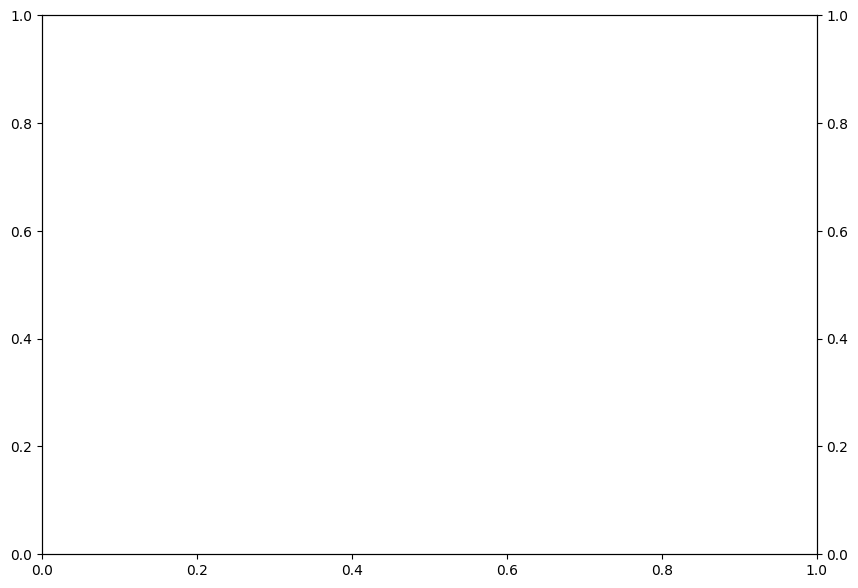

In [83]:
import numpy as np
from util import load_pickle
import os
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from trading_metrics import calculate_metrics
import re
import pandas as pd


def plot_equity(model_name, model_equities, ax1, ax2, plot_hist):
    match = re.search("ws(\d+)", model_name)
    in_obs = int(match.group(1)) if match else 64
    skip_steps = 1024 + in_obs

    sum_equity = None
    buy_trades = []
    sell_trades = []
    for item in model_equities:
        if sum_equity is None:
            sum_equity = item[2]["Equity"].iloc[skip_steps:].copy()
        else:
            sum_equity += item[2]["Equity"].iloc[skip_steps:]
100_000
        if len(item[1]) > 0:
            buy_trades.append(item[1]["EntryTime"])
            sell_trades.append(item[1]["ExitTime"])

    if len(buy_trades) > 0:
        buy_trades = pd.concat(buy_trades)
        sell_trades = pd.concat(sell_trades)

        combined_trades = pd.DataFrame({
            "Buy trades": buy_trades,
            "Sell trades": sell_trades
        })

    start_cash = 1_000_000
    tickers_count = 5
    trades_count = sum(map(lambda x: len(x[1]), model_equities))
    metrics = calculate_metrics(sum_equity, trades_count, start_cash * tickers_count)

    sum_equity = sum_equity.rolling(window=256).mean()[256:]

    y = (sum_equity - start_cash * tickers_count) / (start_cash * tickers_count)

    # Plot line on the primary axis
    ax1.plot(y, markevery=1024, label=model_name)

    # Plot histogram on the secondary axis
    if plot_hist and len(buy_trades) > 0:
        ax2.hist(combined_trades, bins=32, alpha=0.5, label=["Buy trades", "Sell trades"], color=['green', 'red'])

    print()
    print(f"{model_name} metrics:")
    print(f"cumulative_return={metrics[0]:.4f}, "
          f"max_earning_rate={metrics[1]:.4f}, "
          f"maximum_pullback={metrics[2]:.4f}, "
          f"average_profitability_per_trade={metrics[3]:.4f}, "
          f"sharpe_ratio={metrics[4]:.4f}")
    print()


filenames = next(os.walk(f"backtest-results/"), (None, None, []))[2]  # [] if no file
results = {}
for filename in filenames:
    (trades, equity_curve) = load_pickle(f"backtest-results/{filename}")
    parts = filename.split("_")
    model_name = "_".join(parts[:-1])  # Get all parts except the last one as the model name
    coin = parts[-1].split('.')[0]  # Get the last part as the coin, and remove file extension

    if model_name not in results:
        results[model_name] = []
    results[model_name].append((coin, trades, equity_curve, filename))

buy_hold = "Buy and Hold"
buy_hold_res = results.pop(buy_hold)

plt.figure(figsize=(10, 7))

ax1 = plt.gca()
ax2 = ax1.twinx()

for i, model in enumerate(sorted(list(results.keys()))):
    plot_equity(model, results[model], ax1, ax2, True)

    plot_equity(buy_hold, buy_hold_res, ax1, ax2, False)

    ax2.set_ylim([0, max(ax2.get_ylim()[1], ax1.get_ylim()[1])])

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()

    # plt.show()
    plt.savefig(f"pics/figure{i}.png")
    ax1.cla()
    ax2.cla()

In [30]:
list(results.items())[0][1][0][1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,39896,43555,43580,25.065041,25.15,3389.512378,0.003390,2023-08-14 22:58:00,2023-08-14 23:23:00,0 days 00:25:00
1,-39936,43580,69536,25.124850,19.33,231423.117428,0.230642,2023-08-14 23:23:00,2023-09-01 23:59:00,18 days 00:36:00
